## DATA EXTRACTION

STEP1
- Code to extract and save movie-wise shen-parcellated fMRI data from the Human Connectome Project (HCP)'s social task dataset. The dataset has fMRI data from 1048 subjects.
- Task info: subjects watched 20s animations that were labelled by the experimenters and previous studies as "mental" and "random" - 5 stimuli/condition. Participants were asked to rate stimuli as mental, random or unsure after the end of the animation, 
- Our analysis of the behavioral data showed that although participants' reports in general agreed with the expter-assigned labels this was not always the case
- The fMRI data we obtained from the HCP online repository has been already preprocessed by them (motion corrected, unwarping, spatial normalization to MNI space etc. details in Barch et al, 2013, NI).
- Further, voxel-wise data has already been parcellated into 268 ROIs/nodes spanning the whole brain as per Shen parcellation.
- this script: selecting stimulus onset times and duration, creating regressors for block-wise analysis


TERMS/ABBREVIATIONS USED INTERCHANGEABLY:
- movie <-> trial
- mental <-> social <-> "yes" response/responder
- random <-> non-social <-> "no" response/responder
- nodes <-> regions of interest <-> ROIs
- subjects <-> participants <-> subs

@CODE REVIEWER: COMMENTS TO YOU START WITH "@CODE REVIEWER"

REKHA VARRIER, OCTOBER 2021

### Importing packages and parcellated fMRI data, exploring datatypes etc.

In [1]:
# import packages, check folders
#%reset
from pathlib import Path
from datetime import datetime
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'

print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

fmri_dir = "/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha"
os.chdir(fmri_dir)
print('\nchanged current directory to:\n', fmri_dir)


current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code

changed current directory to:
 /Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


## Info needed to isolate stimulus presentation windows


In [3]:
vid_onsets_in_sec = [8, 46, 84, 122, 160] # from analysis by EF

## Verifying some things we know about the behavioral data

### @ CODE REVIEWER: FEEL FREE TO SKIP THIS SECTION. THIS PART ONLY VERIFIES THE STIMULUS ONSET TIMES LISTED ABOVE

- This was already done by EF, double-checking the onset times mentioned above, and also that there is no jitter in stim onset times
- all videos were 20 secs long, TR = .7s


In [9]:
txt_files_loc = os.path.join(fmri_dir,'inscanner_behav_data')
files = os.listdir(txt_files_loc)
print('nr of files',len(files))

nr of files 2087


0 105620_3T_SOCIAL_run1_TAB.txt
vid_num in run: 0 ,onset delay: 2111.0 ,actual: 10.089 , mean: 8


<AxesSubplot:>

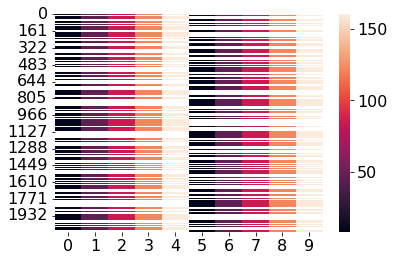

In [25]:
# extracting in-scanner behavioral data
onset_times = np.empty((len(files),10))
onset_times[:] = np.nan
for i,f in enumerate(files):
    #print(f)
    indiv_beh_dat = pd.read_csv(os.path.join(txt_files_loc,f),delimiter='\t')
    baseline = indiv_beh_dat['CountDownSlide.OnsetTime'].values[0]
    o =  indiv_beh_dat['MovieSlide.OnsetTime'].values
    if 'run1' in f:
        cols = np.arange(5)
    else:
        cols = np.arange(5,10)
    onset_times[i,cols] = o[~np.isnan(o)]
    onset_times[i,cols] = onset_times[i,cols] - baseline
    onset_times[i,cols] = onset_times[i,cols]/1000

    onset_delay = indiv_beh_dat['MovieSlide.OnsetDelay'].values
    onset_delay = onset_delay[~np.isnan(onset_delay)]
    
    for vid_no in range(10):
        vid_no_within_run = vid_no%5
        if onset_times[i,vid_no] - vid_onsets_in_sec[vid_no_within_run] > .5: # sub and movie deviating from group mean
            print(vid_no,f)
            print('vid_num in run:',vid_no, ',onset delay:', onset_delay[vid_no_within_run],  ',actual:',onset_times[i,vid_no],', mean:',
            vid_onsets_in_sec[vid_no_within_run])
sns.heatmap(onset_times)

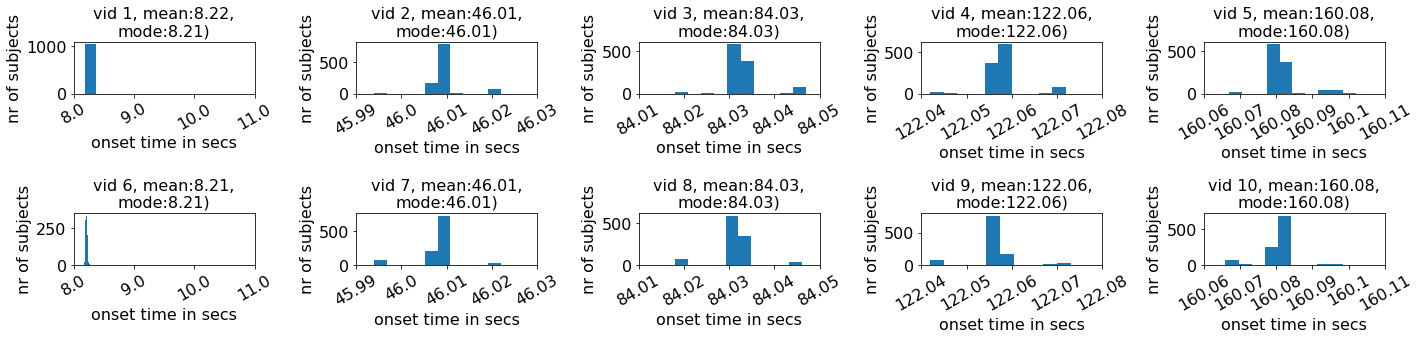

In [43]:
# verifying onset times across subjects
plt.figure(1,figsize = (20,5))

import statistics

for vid_no in range(10):
    plt.subplot(2,5,vid_no+1)
    d = onset_times[~np.isnan(onset_times[:,vid_no]),vid_no]
    if vid_no%5==0:
        plt.xlim(8,11)
    plt.hist(d)
    plt.title(f'vid {vid_no+1}, mean:{np.nanmean(d):.2f},\nmode:{statistics.mode(d):.2f})')
    ticks = plt.xticks()
    ticks = ticks[0]
    plt.xticks(ticks,[np.round(t,2) for t in ticks],rotation =30)
    plt.xlabel ('onset time in secs')
    plt.ylabel("nr of subjects")
plt.tight_layout()


- all except one subject has the same mean as the group - i.e., no jitter overall

- For the subject with the delay (105620, run 1), the stimulus coaxing was only presented for 18s, and presentation onset was 2sec later than the others. Let's exclude this trial from the analyses

- also, 8.2 is a more accurate onset TR for stim 0 in both runs

@CODE REVIEWER: PLEASE CONTINUE FROM HERE.

## Converting onset times to TRs

In [44]:
vid_onsets_in_sec = [8.2, 46, 84, 122, 160]
 # actual time in secs

#exploring the timecourse
print('time between onsets=',np.diff(vid_onsets_in_sec))
task_duration_secs = 20 # stimulus presentation duration
RW_secs = 3
fix_window_secs = np.diff(vid_onsets_in_sec)[0] - (task_duration_secs+RW_secs)
print('task:',task_duration_secs,'\nRW:',RW_secs,'\nfixation:',fix_window_secs,'secs')


time between onsets= [37.8 38.  38.  38. ]
task: 20 
RW: 3 
fixation: 14.799999999999997 secs


In [45]:
np.diff(vid_onsets_in_sec)

array([37.8, 38. , 38. , 38. ])

In [62]:
#converting onset times to TRs
tr = 0.72
vid_onsets_imagenr = np.zeros_like(vid_onsets_in_sec)
for i in range(5):
    #vid_onsets_imagenr[i] = np.floor((vid_onsets_in_sec[i]/tr)-1) # safer to subtract one, but in our study, we'd start too early then
    vid_onsets_imagenr[i] = np.floor(vid_onsets_in_sec[i]/tr) # seconds to image nr 
    # this is already 0-indexed, we don't need to subtract 1 to account for the zero index, because the first image starts at time 0 too 
    # (e.g. TR index would've been 0 if stim started at t=0 secs, or 1 if 
    # stim had started at tr=.72 seconds exactly and so on).
print('video onsets in TRs:',vid_onsets_imagenr) #this is the INDEX to be used!! do not subtract 1 again


video onsets in TRs: [ 11.  63. 116. 169. 222.]


- comment from reviewer (Katie) about secs  to TR conversion - " I did a check where I added 1 to the tr timepoints and actually got a closer fit to the original timepoints. Any sense of why that's happening?"

Answer: Since the conversion is an approximation, and we don't want to miss out on early activity for some of the analyses, I used a floor funciton while converting - resulting if anything in earlier TRs than later TRs - does this make sense? Also, on looking into it further (see below), adding 1 helps some cases (e.g. 2nd and 3rd movie) a lot, but not the other cases (e.g. 1st,4th and 5th images)

vid_onsets_in_sec: [8.2, 46, 84, 122, 160]
(vid_onsets_imagenr+1)*.72: [  8.64  46.08  84.24 122.4  160.56]
(vid_onsets_imagenr)*.72: [  7.92  45.36  83.52 121.68 159.84]


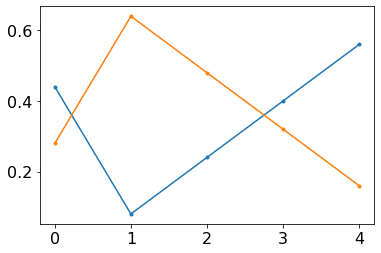

In [63]:
print('vid_onsets_in_sec:',vid_onsets_in_sec)
print('(vid_onsets_imagenr+1)*.72:',(vid_onsets_imagenr+1)*.72)
print('(vid_onsets_imagenr)*.72:',(vid_onsets_imagenr)*.72)
#plt.plot(vid_onsets_in_sec,marker='.')
plt.plot(range(5),np.abs(vid_onsets_in_sec-(vid_onsets_imagenr+1)*.72),marker='.')
plt.plot(range(5),np.abs(vid_onsets_in_sec-(vid_onsets_imagenr)*.72),marker='.')

In [64]:
np.nanmedian(np.abs(vid_onsets_in_sec-(vid_onsets_imagenr+1)*.72))

0.3999999999999915

In [65]:
np.nanmedian(np.abs(vid_onsets_in_sec-(vid_onsets_imagenr)*.72))

0.3200000000000074

### Is the conversion to TR fine?
- checked by converting onset TRs back into seconds to see how close it is to the original TRs

1: [  7.92  45.36  83.52 121.68 159.84]
2: [  7.2   44.64  82.8  120.96 159.12]
Red is the correct one, magenta should be used only if the video has t=0 at the timept before the first t=1


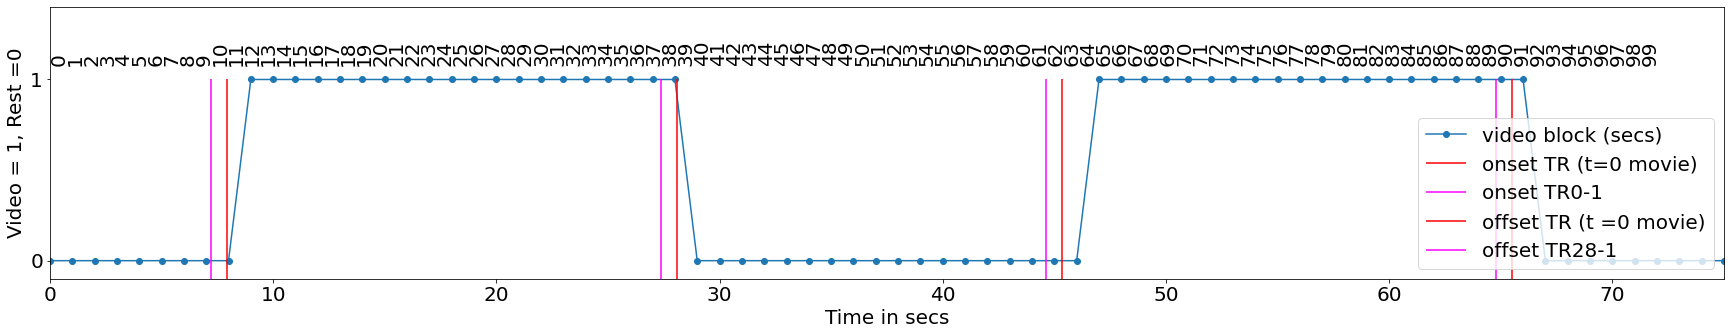

In [66]:
print('1:',vid_onsets_imagenr*tr) # converting TRs to time in secs (red in the figure below)
print('2:',(vid_onsets_imagenr-1)*tr) # alternate algorithm which would've gone back one additional image in TR assignment. 
# (pink in the figure below)
#1 is  pretty close to actual onset times --> the conversion we did is fine

# visualization (purpose of these was to ascertain that the t=0 point is the correct onset point)
# for one-on-one meeting on 17.08.21
x = np.zeros((181,))
for i in range(len(vid_onsets_in_sec)):
    x[int(vid_onsets_in_sec[i])+1:int(vid_onsets_in_sec[i])+21] = 1 # time 0 to time 20 is 21 points. 
    #but start counting only from the first "1" timept - call it TR=0 (not 1)
plt.figure(1,figsize = (30,5))
plt.plot(x,marker = 'o', label = 'video block (secs)')
x_ims = [tr*i for i in range(int(np.ceil(181/tr)))]
x_ims
#for i in vid_onsets_imagenr:
#    plt.vlines(x_ims[i-5:i+5],-1,1)
plt.vlines(vid_onsets_imagenr*tr       ,-1,1,color = 'r',       label = 'onset TR (t=0 movie)')
plt.vlines((vid_onsets_imagenr-1)*tr   ,-1,1,color = 'magenta', label = 'onset TR0-1')
plt.vlines((vid_onsets_imagenr+28)*tr,-1,1,color = 'r',       label = 'offset TR (t =0 movie)')
plt.vlines((vid_onsets_imagenr+28-1)*tr  ,-1,1,color = 'magenta', label = 'offset TR28-1')
print('Red is the correct one, magenta should be used only if the video has t=0 at the timept before the first t=1')
plt.xticks(fontsize =20)
plt.yticks([0,1],fontsize =20)
for i in range(len(x_ims[:100])):
    plt.text(x_ims[i],1.1,i,rotation=90,fontsize = 20)
plt.ylim(-.1,1.4)
plt.xlim(0,75)
plt.xlabel('Time in secs',fontsize =20)
plt.ylabel('Video = 1, Rest =0',fontsize =20)
plt.legend(fontsize =20, loc = 'lower right')

from the figure above, the red line corresponding to onset TR = 8secs corresponds to t=0 better

In [67]:
vid_onsets_imagenr

array([ 11.,  63., 116., 169., 222.])

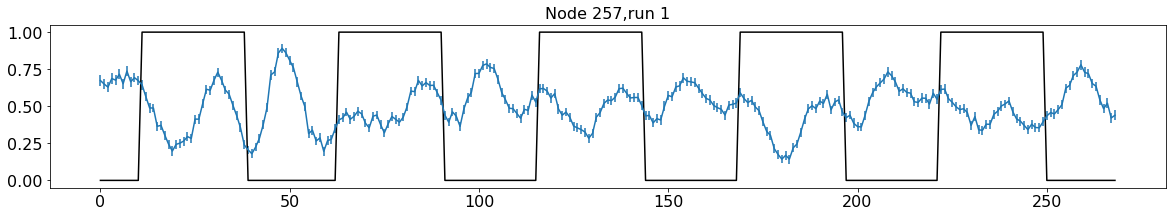

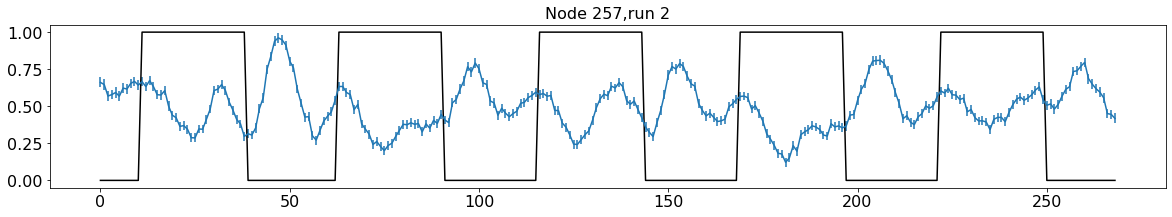

In [68]:
#testing timecourses

timecourses = np.load(os.path.join(data_file_loc,'timecourses.npy'))
timecourses.shape
n= 256
plt.figure(1,figsize=(20,3))
plt.title(f'Node {n+1},run 1')
plt.errorbar(range(269),np.nanmean(timecourses[:,n,:,0],axis=0)+.5,stats.sem(timecourses[:,n,:,0],axis=0))
box = np.zeros((269,))
for i in range(5):
    box[int(vid_onsets_imagenr[i]):int(vid_onsets_imagenr[i])+28] = 1
plt.plot(range(269),box,color = 'k')
#plt.vlines(vid_onsets_imagenr       ,-.4,.4,color = 'r',       label = 'onset TR (t=0 movie)')
#plt.vlines((vid_onsets_imagenr+28),-.4,.4,color = 'grey', ls='dashed',       label = 'offset TR (t =0 movie)')

plt.figure(2,figsize=(20,3))
plt.title(f'Node {n+1},run 2')
plt.errorbar(range(269),np.nanmean(timecourses[:,n,:,1],axis=0)+.5,stats.sem(timecourses[:,n,:,1],axis=0))
plt.plot(range(269),box,color = 'k')
#plt.vlines(vid_onsets_imagenr       ,-.4,.4,color = 'r',       label = 'onset TR (t=0 movie)')
#plt.vlines((vid_onsets_imagenr+28),-.4,.4,color = 'grey', ls='dashed',       label = 'offset TR (t =0 movie)')


In [69]:
vid_onsets_imagenr

array([ 11.,  63., 116., 169., 222.])

Text(121.0, -0.5, 'STAR')

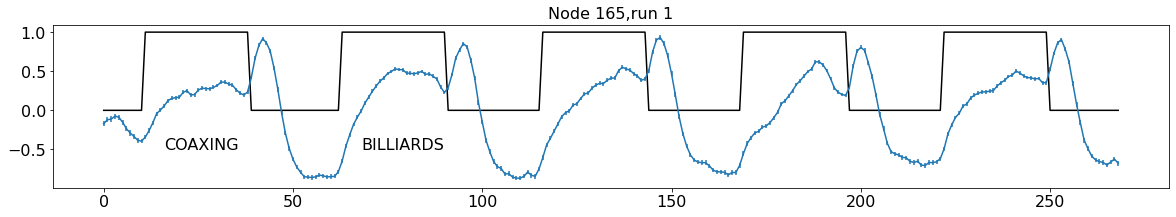

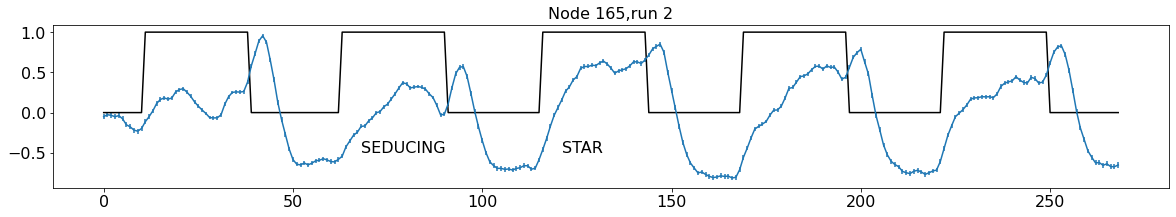

In [70]:
#testing timecourses

timecourses = np.load(os.path.join(data_file_loc,'timecourses.npy'))
timecourses.shape
n= 164
plt.figure(1,figsize=(20,3))
plt.title(f'Node {n+1},run 1')
plt.errorbar(range(269),np.nanmean(timecourses[:,n,:,0],axis=0),stats.sem(timecourses[:,n,:,0],axis=0))
box = np.zeros((269,))
for i in range(5):
    box[int(vid_onsets_imagenr[i]):int(vid_onsets_imagenr[i])+28] = 1
plt.plot(range(269),box,color = 'k')
#plt.vlines(vid_onsets_imagenr       ,-.4,.4,color = 'r',       label = 'onset TR (t=0 movie)')
#plt.vlines((vid_onsets_imagenr+28),-.4,.4,color = 'grey', ls='dashed',       label = 'offset TR (t =0 movie)')
plt.text(vid_onsets_imagenr[0]+5,-.5,'COAXING')
plt.text(vid_onsets_imagenr[1]+5,-.5,'BILLIARDS')

plt.figure(2,figsize=(20,3))
plt.title(f'Node {n+1},run 2')
plt.errorbar(range(269),np.nanmean(timecourses[:,n,:,1],axis=0),stats.sem(timecourses[:,n,:,1],axis=0))
plt.plot(range(269),box,color = 'k')
#plt.vlines(vid_onsets_imagenr       ,-.4,.4,color = 'r',       label = 'onset TR (t=0 movie)')
#plt.vlines((vid_onsets_imagenr+28),-.4,.4,color = 'grey', ls='dashed',       label = 'offset TR (t =0 movie)')
plt.text(vid_onsets_imagenr[1]+5,-.5,'SEDUCING')
plt.text(vid_onsets_imagenr[2]+5,-.5,'STAR')

In [71]:
print('nr. of TRs between onsets:',np.diff(vid_onsets_imagenr)) # sanity check: are the distances between onset images the same?
print(' onset TRs are evenly distributed - as expected, since there was no jitter in onset')

l_task = int(np.round(task_duration_secs/tr))  # duration measured in nr of images = 28 for 20s
print('Duration of task block in nTRs:', l_task)


nr. of TRs between onsets: [52. 53. 53. 53.]
 onset TRs are evenly distributed - as expected, since there was no jitter in onset
Duration of task block in nTRs: 28


In [72]:
n_init_TRs_to_delete = 5 
vid_onsets_imagenr -= n_init_TRs_to_delete # adjust for the removal of the first 5 TRs
vid_onsets_imagenr = np.array([int(i) for i in vid_onsets_imagenr])
vid_onsets_imagenr
# right now, t=0 is the timept immediately before a video. Henceor the GLM analyses, the first TR should be assigned a value of 0 since it's BEFORE the start
# of a movie (i.e., movie reg should be assigned np.arange(0,1,29)).
# So TR=0 (i.e., timept immediately before the onset)
# There is no video at TR=6 within the selected block (hence it's the baseline), whereas the movie would've started in TR=7
# IN ALL FUTURE ANALYSES, REMEMBER TO (1) BASELINE-CORRECT W.R.T. the vid_onsets_imagenr valuee mentioned here!! , (2) THAT AT THIS TR, THERE IS NO MOVIE YET!! MOVIE STARTS
# AT TR=VID_ONSETS_IMAGENR+1

array([  6,  58, 111, 164, 217])

## Extract TRs for each movie

- store a list of TRs relevant for each movie - starting from onset TR-n to TR+viddur+n 

- note that, we include the TR corresponding approximately to t=0 of movies as the last fixation point. Ther reason, as mentioned above is that since the stimulus hasn't yet been presented at t=0, only after, so we don't need this TR for the regressor coefft. However, note that this means that for the timecourse analysis, the first timept stored for each movie will be TR=1 (or approx 700ms after the first movie - assuming no estimation errors in converting from secs to TRs)

In [79]:
l_task = int(np.round(task_duration_secs/tr))  # duration of video measured in #TRs = 28 for 20s
print('Duration of task block:', l_task) # + 1 additional tr

fix_duration_secs = 15
l_fix = int(np.round(fix_duration_secs/tr))
print('Nr of fixation images:', l_fix)

Duration of task block: 28
Nr of fixation images: 21


In [81]:
# specify whether to include pre-/post-stim fixation TRs

include_post_task_fixation = True # change to 1 to include 15 TRs after task or -1 to include
include_pre_task_fixation = True

# 3 baseline TRs
if (include_post_task_fixation == True) and (include_pre_task_fixation== False): 
    #preproc used Jan-June

    #l = 34 # duration    
    l_fix_start = 0 # nr of fixation pts before the start
    l_fix_end = int(l_task/2) #  nr of fixation pts after the end
    
    l_resp_screen = int(np.round(3/tr))
    print("Duration of resp screen:", l_resp_screen)

elif (include_post_task_fixation == True) and (include_pre_task_fixation== True):
    # for analyses in the final results
    l_fix_start = int(l_task/2) -1  # 13 here + 1 baseline in task block (i.e.,TR=0 in the task block) + 14 pre-task TRs
    l_fix_end = int(l_task/2) # 14 post-task TRs
    
# check if TRs are correct
print('TRs before vid: l_fix_start=',l_fix_start,'\nTRs after vid: l_fix_end=',l_fix_end)
print('l_task:',l_task)


TRs before vid: l_fix_start= 13 
TRs after vid: l_fix_end= 14
l_task: 28


In [82]:
vid_onsets_imagenr # 0-indexed, TR that can be considered t=0 for each image

array([  6,  58, 111, 164, 217])

In [86]:
[timepts_indiv_movie1,vid_start_rel_tr1] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'), allow_pickle =True) 
timepts_indiv_movie1[1]

array([ 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100])

In [88]:
# Store moviewise time windows

nmovies = 10
timepts_indiv_movie = [] # to store timepts (prestim fix if applicable + stim + poststim fix) for each movie

vid_start_rel_tr = []
for vid_no in range(nmovies):
    run = "run1" if vid_no < 5 else "run2"
    vid_no_withinrun = vid_no%5
    #vid = vid_names[run][vid_no_withinrun]
    #print(vid)
    
    if vid_no%5 == 0: # first video in run 1 or 2
        start_frame = 0 # the first element of the array (after removing the 1st 5 TRs)
        vid_start_rel_tr.append(int(vid_onsets_imagenr[0])) # remember that by onset, we mean the very first image (i.e., the TR immediately before stim onset!!)
    else:
        start_frame = int(vid_onsets_imagenr[vid_no_withinrun]) - l_fix_start # vid start TR index - nr. of pre-baseline (baseline= tr immediately before stim onset)
        # images
        vid_start_rel_tr.append(l_fix_start)# vid start TR index = nr. of fixation images (e.g. because of 0-indexing, the video start index (e.g. 1 (i.e., the second scan))=
        # nr. of fixations before it (e.g. 1 image before the second scan)
    
    end_frame = int(vid_onsets_imagenr[vid_no_withinrun]) + 1 + l_task + l_fix_end # vid start TR index + 1 (to account for the start_index being prestim) + 
    # nr. of task TRs) + nr. of post-task images
    # NOT "+ (l_task-1) " because we still need from timepts 1 to 28 (np.arange(1,1+28)).
    
    timepts = np.arange(start_frame, end_frame) 
    timepts_indiv_movie.append(timepts)  # timepts (prestim fix + stim) for each movie

np.save(os.path.join(data_file_loc,'Video_TRs.npy'),[timepts_indiv_movie,vid_start_rel_tr]) 
# to be clear, timepts_indiv_movie has (except for movies 0 and 5), 13 pts before and 14 pts after the movie, 29 pts corresponding to the baseline + movie (0,1...28), 
# and 14 pts after.
# vid_start_rel_tr is the index within timepts_indiv_movie which is the TR=0 index.  for a block design, the GLM boxcar becomes 1 at the index following this point.
# (vid_start_rel_tr+1) would be TR=1
print('nr of timepts per movie:',[timepts_indiv_movie[i].shape for i in range(10)]) 
# 3 prestim, images start to start+28 (incl edges, so 29)

#print(timepts_indiv_movie) # list of 10, each item consists of TRs relevant to that movie within its run.
# for analyses post June: t0-3 to t0+28
print(vid_onsets_imagenr)
for i in range(10):
    print(timepts_indiv_movie[i][vid_start_rel_tr[i]]) #within-movie TR. If it matches with vid_onsets_tr, we got the TRs right.

nr of timepts per movie: [(49,), (56,), (56,), (56,), (56,), (49,), (56,), (56,), (56,), (56,)]
[  6  58 111 164 217]
6
58
111
164
217
6
58
111
164
217


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [94]:
vid_onsets_imagenr

array([  6,  58, 111, 164, 217])

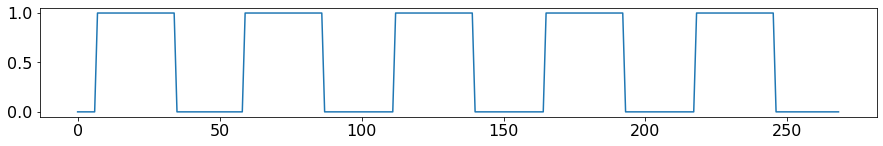

In [96]:
# illustrating the usage of the indices above
boxcar_reg = np.zeros((269,))
for i in range(5):
    inds = np.arange(vid_onsets_imagenr[i]+1,vid_onsets_imagenr[i]+1+l_task) # adding 1 because vid_onsets_imagenr[i] is the TR immediately before stim onset and 
    # hence this index should still  have the value 0
    inds = [int(i) for i in inds]
    boxcar_reg[inds] = 1
plt.figure(1,figsize=(15,2))
plt.plot(boxcar_reg)
np.save(os.path.join(data_file_loc,'boxcar_run.npy'),boxcar_reg)


# extra code

In [ ]:
# checking simulations of normalizations

plt.figure(1,figsize =(15,5))
plt.subplot(131)
x1 = np.zeros((20,))+2
x1[15:] = 22
x1[5:14] = np.linspace(2,22,9)
plt.plot(x1,marker ='o',color = 'k')
plt.title('simulated raw values')
x2= np.arange(0,20)+2
plt.plot(x2,marker ='o',color = 'm')

#plt.ylim(-2,22)
plt.text(0,18,f'mean:{x1.mean():.2f},\nstd:{x1.std():.2f}',color = 'k')
plt.text(0,15,f'mean:{x2.mean():.2f},\nstd:{x2.std():.2f}',color = 'm')

#x.mean()
plt.subplot(132)
#plt.ylim(-2,22)
plt.title('dividing by std dev')
x1 = stats.zscore(x1)
x1 = x1-x1[0]
x2 = stats.zscore(x2)
x2 = x2-x2[0]
plt.plot(x1,color = 'k')
plt.plot(x2,color = 'm')


plt.subplot(133)
plt.title('dividing by max-min')
#plt.ylim(-2,22)
x1 = x1-x1.mean()
x1 = x1/(max(x1)-min(x1))
x1 = x1-x1[0]
x2 = x2-x2.mean()
x2 = x2/(max(x2)-min(x2))
x2 = x2-x2[0]
plt.plot(x1,color = 'k')
plt.plot(x2,color = 'm')


In [ ]:
elif (include_post_task_fixation == False) and (include_pre_task_fixation== True):
    # for timecourse analyses
    
    l_fix_start = 3 # 3 pre-task TRs
    l_fix_end = 0
